In [1]:
# Useful imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import networkit as nk
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from src.helpers import *
from scipy.stats import normaltest
# import ipywidgets as widgets
# from ipywidgets import interact
pd.options.mode.chained_assignment = None  

In [2]:
ethn_div = pd.read_csv('generated/ethnicity_diversity.csv', sep=',')
gen_div = pd.read_csv('generated/gender_diversity.csv', sep=',')

In [3]:
print(ethn_div.columns)
print(ethn_div.shape[0])
print(gen_div.columns)
print(gen_div.shape[0])

Index(['movie_freebase_id', 'movie_name', 'movie_release_year',
       'movie_languages_count', 'movie_genres', 'ethnicity_diversity',
       'actors_count', 'rating_average', 'rating_count',
       'movie_box_office_revenue'],
      dtype='object')
12640
Index(['movie_freebase_id', 'movie_name', 'movie_release_year',
       'movie_languages_count', 'movie_genres', 'gender_diversity',
       'actors_count', 'rating_average', 'rating_count',
       'movie_box_office_revenue'],
      dtype='object')
29887


In [4]:
# str1 = ethn_div.movie_genres.iloc[4]
# str0 = ethn_div.movie_genres.iloc[0]
# list1 = [genre.strip() for genre in str1.strip("[]").split(",")]
# list2 = [genre.strip() for genre in str0.strip("[]").split(",")]
# print(list1)
# print(list2)
# #common_movie_gender(str1, str0)
# #print(ethn_div['movie_genres'].unique())
# for id, row in ethn_div.iterrows():
#     print(row['movie_genres'])
#     print(common_movie_gender(row['movie_genres'], row['movie_genres']))
#     break

In [5]:
def common_movie_gender(str1, str2):  #check if two movies have at least one common genre
    # Convert string representation of lists to actual lists
    list1 = [genre.strip() for genre in str1.strip("[]").split(",")]
    list2 = [genre.strip() for genre in str2.strip("[]").split(",")]

    set1 = set(list1)
    set2 = set(list2)
    common_elements = set1.intersection(set2)

    if common_elements:
        return True
    else:
        return False
    

def add_propensity_score(df, formula):
    #df = standardize_continuous_features(df)
    mod = smf.ols(formula= formula, data=df)
    res = mod.fit()
    df['Propensity_score'] = res.predict()
    return df

def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

def binarize(df, performance_param):
    if performance_param == 'box_office':
        median_value = df['movie_box_office_revenue'].median()
        df['movie_box_office_binary'] = np.where(df['movie_box_office_revenue'] > median_value, 1, 0)
    elif performance_param == 'rating':
        median_value = df['rating_average'].median()
        df['rating_binary'] = np.where(df['rating_average'] > median_value, 1, 0)
    else:
        print("Invalid performance parameter")
        return None
    return df

def compute_balance_df(df, perfomance_param): 
    # Separate the treatment and control groups
    if perfomance_param == 'box_office':
        treatment_df = df[df['movie_box_office_binary'] == 1]
        control_df = df[df['movie_box_office_binary'] == 0]

    elif perfomance_param == 'rating':
        treatment_df = df[df['rating_binary'] == 1]
        control_df = df[df['rating_binary'] == 0]
    else:
        print("Invalid performance parameter")
        return None
    
    print("treatment size:",treatment_df.shape[0])
    print("control size:",control_df.shape[0])

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():
            if (control_row['movie_languages_count'] == treatment_row['movie_languages_count']) and common_movie_gender(control_row['movie_genres'], treatment_row['movie_genres']):
                # Calculate the similarity 
                similarity = get_similarity(control_row['Propensity_score'],
                                            treatment_row['Propensity_score'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.loc[matched]
    return balanced_df

def regression(df,formula,performance_param):
    df = add_propensity_score(df, formula)
    df =binarize(df, performance_param)
    balanced_df = compute_balance_df(df,performance_param)
    mod = smf.ols(formula=formula, data=balanced_df)
    res = mod.fit()
    #print(res.summary())
    return balanced_df,mod

In [6]:

def filtering(df, performance_param):
    df_copy = df.copy()
    if (performance_param == 'box_office'):
        df_copy.dropna(subset=['movie_box_office_revenue'],inplace=True)
        return df_copy

    elif (performance_param == 'rating'):
        df_copy.dropna(subset=['rating_average'],inplace=True)
        df_bis = df_copy[df_copy['rating_count'] > 100]
        return df_bis

    else:
        print("Invalid parameters")
        
    

def year_release_split(df, number_parts):
    total_size = df.shape[0]
    share = int(total_size/(number_parts))
    cumulative_data = df['movie_release_year'].value_counts().sort_index().cumsum()
    cutoff = []
    for i in range(number_parts):
        relevant_data = cumulative_data[cumulative_data > (i)*share] 
        if not relevant_data.empty:
            cutoff.append(relevant_data.index[0])

    period_dataframes = {}
    for i in range(len(cutoff)):
        if i < len(cutoff)-1:
            period_df = df[
                (df['movie_release_year'] > cutoff[i]) &
                (df['movie_release_year'] <= cutoff[i+1])
            ]
        if i == len(cutoff)-1:
            period_df = df[
                (df['movie_release_year'] > cutoff[i])
            ]

        period_dataframes[f'df_period{i+1}'] = period_df
    return period_dataframes,cutoff  # period_dataframes['df_period1']


### Ethnicity-Box office

In [7]:
ethn_div_filter = filtering(ethn_div,'box_office')
print('Size of Ethnicity :',ethn_div_filter.shape[0])
nbr = 10
period_df ,cutoff = year_release_split(ethn_div_filter, nbr)
# tot =0
# for i in range(1,nbr+1):
#     print(i,":",period_df[f'df_period{i}'].shape[0])
#     tot = tot + period_df[f'df_period{i}'].shape[0]
# print(tot)




Size of Ethnicity : 4683


In [8]:
balanced_df1,mod1 = regression(period_df['df_period1'],'movie_box_office_revenue ~ ethnicity_diversity', 'box_office')
balanced_df2, mod2 = regression(period_df['df_period2'],'movie_box_office_revenue ~ ethnicity_diversity', 'box_office')
balanced_df3,mod3 = regression(period_df['df_period3'],'movie_box_office_revenue ~ ethnicity_diversity', 'box_office')
balanced_df4,mod4 = regression(period_df['df_period4'],'movie_box_office_revenue ~ ethnicity_diversity', 'box_office')
balanced_df5,mod5 = regression(period_df['df_period5'],'movie_box_office_revenue ~ ethnicity_diversity', 'box_office')
balanced_df6,mod6 = regression(period_df['df_period6'],'movie_box_office_revenue ~ ethnicity_diversity', 'box_office')
balanced_df7,mod7 = regression(period_df['df_period7'],'movie_box_office_revenue ~ ethnicity_diversity', 'box_office')
balanced_df8,mod8 = regression(period_df['df_period8'],'movie_box_office_revenue ~ ethnicity_diversity', 'box_office')
balanced_df9,mod9 = regression(period_df['df_period9'],'movie_box_office_revenue ~ ethnicity_diversity', 'box_office')
balanced_df10,mod10 = regression(period_df['df_period10'],'movie_box_office_revenue ~ ethnicity_diversity', 'box_office')

treatment size: 235
control size: 237
treatment size: 243
control size: 243
treatment size: 244
control size: 244
treatment size: 223
control size: 223
treatment size: 279
control size: 280
treatment size: 220
control size: 221
treatment size: 221
control size: 221
treatment size: 275
control size: 275
treatment size: 198
control size: 198
treatment size: 199
control size: 199


In [9]:
def plot_regression_line(balanced_df1,balanced_df2,balanced_df3,balanced_df4,balanced_df5,balanced_df6,balanced_df7,
                         balanced_df8,balanced_df9,balanced_df10,mod1,mod2,mod3,mod4,mod5,mod6,mod7,mod8,mod9,mod10,
                         cutoff,param_div,param_perf,xlabel='Ethnicity Diversity',ylabel='Box Office Revenue'):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 6))

    axes = axes.flatten()
    #dropdown = [ str(int(cutoff[i]))+str('-')+str(int(cutoff[i+1])) for i in range(len(cutoff)-1)]
    #dropdown.append(str(int(cutoff[len(cutoff)-1]))+str('-')+str(int(balanced_df10["movie_release_year"].max())))
    for i, (df, mod) in enumerate([(balanced_df1, mod1), (balanced_df2, mod2), (balanced_df3, mod3), (balanced_df4, mod4), (balanced_df5, mod5), (balanced_df6, mod6), (balanced_df7, mod7), (balanced_df8, mod8), (balanced_df9, mod9), (balanced_df10, mod10)]):
        intercept_coef = mod.fit().params['Intercept']
        ethnicity_coef = mod.fit().params[param_div]
        x_values = np.linspace(min(df[param_div]), max(df[param_div]), 100)
        y_values = intercept_coef + ethnicity_coef * x_values
        axes[i].plot(x_values, y_values, color='red', label='Regression Line')
        axes[i].scatter(df[param_div], df[param_perf], s=5)
        axes[i].set_xlabel(f'{xlabel}: pval= {mod.fit().pvalues[param_div].round(3)}, intercept pval= {mod.fit().pvalues["Intercept"].round(3)}')
        axes[i].set_ylabel(ylabel)
        if i < len(cutoff)-1:
            axes[i].set_title(f'{int(cutoff[i])} - {int(cutoff[i+1])}')
        if i == len(cutoff)-1:
            axes[i].set_title(f'{int(cutoff[i])} - {int(df["movie_release_year"].max())}')
    plt.tight_layout()
    plt.show()

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
# from ipywidgets import interact, widgets
# import statsmodels.api as sm

# def plot_regression_line(balanced_dfs, mods, cutoff, param_div, param_perf, xlabel='Ethnicity Diversity', ylabel='Box Office Revenue'):
#     def update_plot(selected_df_index):
#         fig, ax = plt.subplots(figsize=(8, 6))
#         df = balanced_dfs[selected_df_index]
#         mod = mods[selected_df_index]

#         intercept_coef = mod.fit().params['Intercept']
#         ethnicity_coef = mod.fit().params[param_div]
#         x_values = np.linspace(min(df[param_div]), max(df[param_div]), 100)
#         y_values = intercept_coef + ethnicity_coef * x_values

#         ax.plot(x_values, y_values, color='red', label='Regression Line')
#         ax.scatter(df[param_div], df[param_perf], s=5)
#         ax.set_xlabel(f'{xlabel}: pval= {mod.fit().pvalues[param_div].round(3)}, intercept pval= {mod.fit().pvalues["Intercept"].round(3)}')
#         ax.set_ylabel(ylabel)
#         ax.set_title(f'{int(cutoff[selected_df_index])} - {int(df["movie_release_year"].max())}')

#         plt.show()

#     # Create interactive dropdown menu
#     dropdown = [str(int(cutoff[i])) + '-' + str(int(cutoff[i + 1])) for i in range(len(cutoff) - 1)]
#     dropdown.append(str(int(cutoff[len(cutoff) - 1])) + '-' + str(int(balanced_dfs[-1]["movie_release_year"].max())))

#     interact(update_plot, selected_df_index=widgets.Dropdown(options=range(len(balanced_dfs)), description='Select DF'))

# # Example usage
# plot_regression_line([balanced_df1, balanced_df2, balanced_df3, balanced_df4, balanced_df5,
#                       balanced_df6, balanced_df7, balanced_df8, balanced_df9, balanced_df10],
#                      [mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8, mod9, mod10],
#                      cutoff, 'ethnicity_diversity', 'movie_box_office_revenue')


In [11]:
# a  =[ str(int(cutoff[i]))+str('-')+str(int(cutoff[i+1])) for i in range(len(cutoff)-1)]
# a.append(str(int(cutoff[-1]))+str('-')+str(int(period_df['df_period10']['movie_release_year'].max())))
# dropdown = widgets.Dropdown(
#     #value='1925-', 
#     options=a, 
#     description='dropdown')

# widgets.VBox(
#     [ 
#         dropdown
#     ]
# )

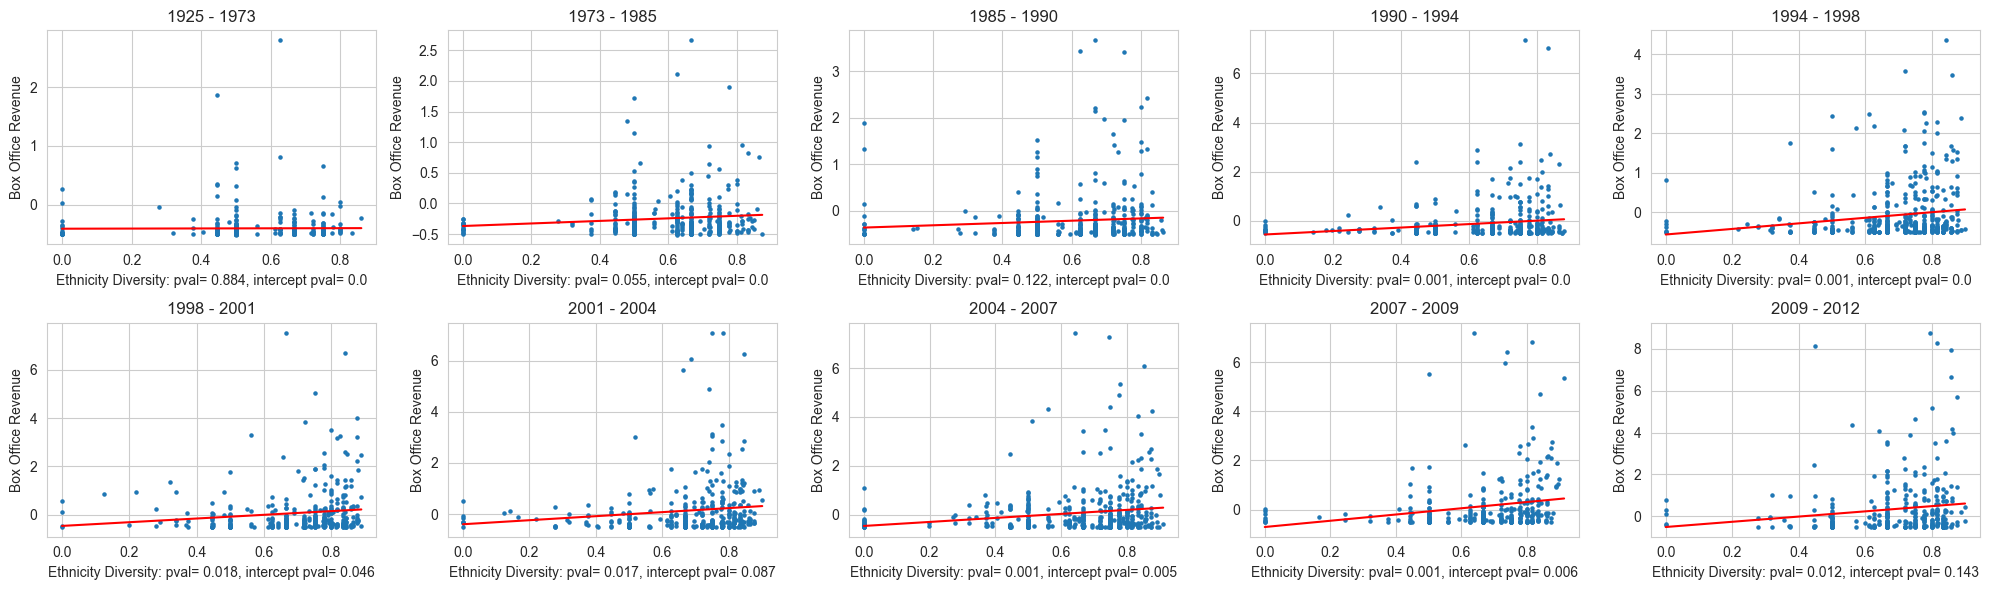

In [12]:
plot_regression_line(balanced_df1,balanced_df2,balanced_df3,balanced_df4,balanced_df5,balanced_df6,balanced_df7,
                     balanced_df8,balanced_df9,balanced_df10,mod1,mod2,mod3,mod4,mod5,mod6,mod7,mod8,mod9,mod10,
                     cutoff,'ethnicity_diversity','movie_box_office_revenue')

### Gender - Box office

In [13]:
gen_div_filter = filtering(gen_div,'box_office')
print('Size of Gender :',gen_div_filter.shape[0])
period_df_gb ,cutoff_gb = year_release_split(gen_div_filter, 10)
# tot =0
# for i in range(1,nbr+1):
#     print(i,":",period_df[f'df_period{i}'].shape[0])
#     tot = tot + period_df[f'df_period{i}'].shape[0]
# print(tot)


Size of Gender : 5600


In [14]:
balanced_df1_gb,mod1_gb = regression(period_df_gb['df_period1'],'movie_box_office_revenue ~ gender_diversity', 'box_office')
balanced_df2_gb,mod2_gb = regression(period_df_gb['df_period2'],'movie_box_office_revenue ~ gender_diversity', 'box_office')
balanced_df3_gb,mod3_gb = regression(period_df_gb['df_period3'],'movie_box_office_revenue ~ gender_diversity', 'box_office')
balanced_df4_gb,mod4_gb = regression(period_df_gb['df_period4'],'movie_box_office_revenue ~ gender_diversity', 'box_office')
balanced_df5_gb,mod5_gb = regression(period_df_gb['df_period5'],'movie_box_office_revenue ~ gender_diversity', 'box_office')
balanced_df6_gb,mod6_gb = regression(period_df_gb['df_period6'],'movie_box_office_revenue ~ gender_diversity', 'box_office')
balanced_df7_gb,mod7_gb = regression(period_df_gb['df_period7'],'movie_box_office_revenue ~ gender_diversity', 'box_office')
balanced_df8_gb,mod8_gb = regression(period_df_gb['df_period8'],'movie_box_office_revenue ~ gender_diversity', 'box_office')
balanced_df9_gb,mod9_gb = regression(period_df_gb['df_period9'],'movie_box_office_revenue ~ gender_diversity', 'box_office')
balanced_df10_gb,mod10_gb = regression(period_df_gb['df_period10'],'movie_box_office_revenue ~ gender_diversity', 'box_office')

treatment size: 285
control size: 292
treatment size: 270
control size: 273
treatment size: 317
control size: 317
treatment size: 290
control size: 291
treatment size: 287
control size: 288
treatment size: 267
control size: 267
treatment size: 284
control size: 285
treatment size: 261
control size: 262
treatment size: 318
control size: 318
treatment size: 201
control size: 201


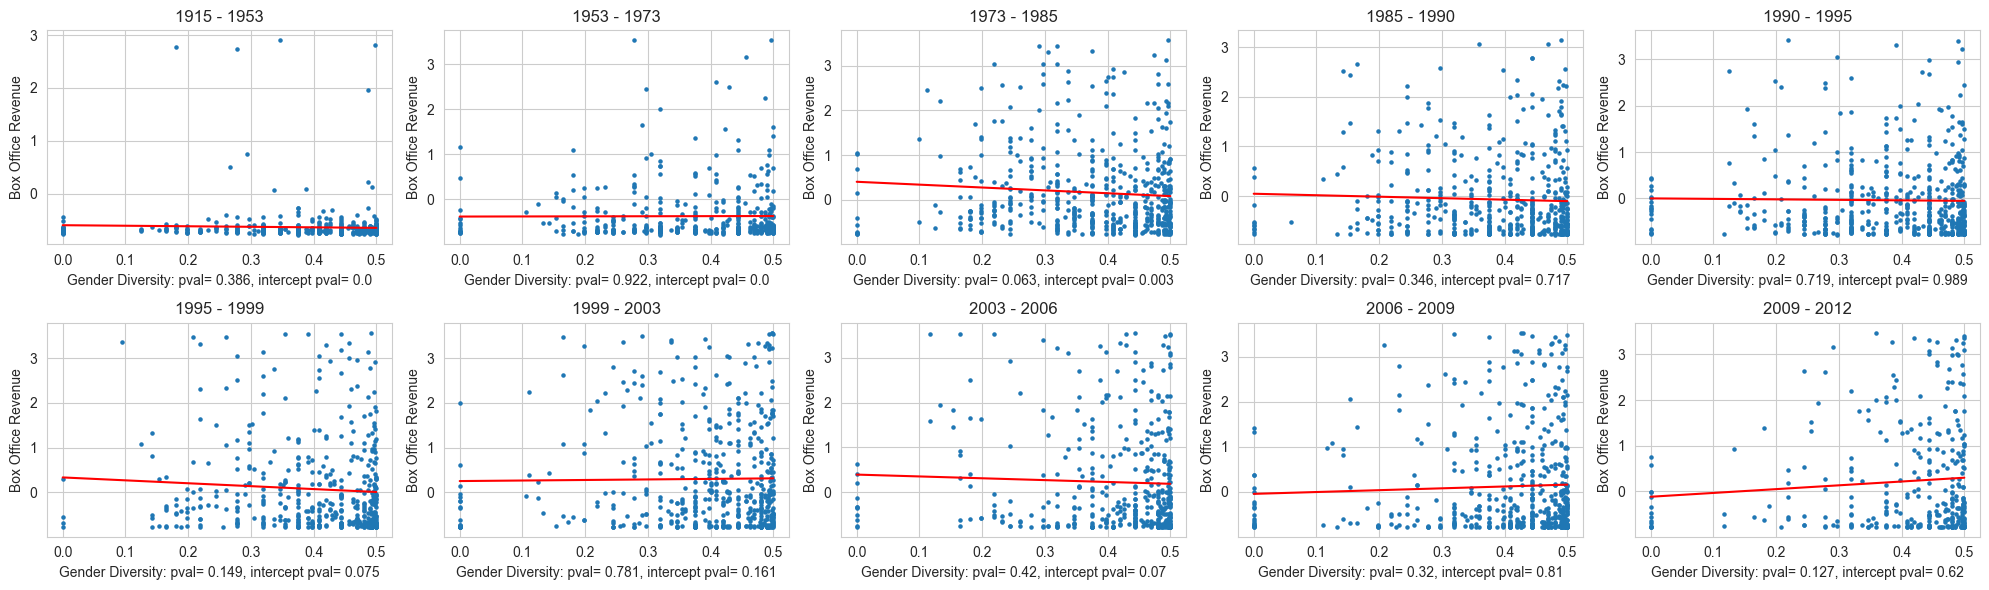

In [15]:
plot_regression_line(balanced_df1_gb,balanced_df2_gb,balanced_df3_gb,balanced_df4_gb,balanced_df5_gb,balanced_df6_gb
                     ,balanced_df7_gb,balanced_df8_gb,balanced_df9_gb,balanced_df10_gb,mod1_gb,mod2_gb,mod3_gb,mod4_gb
                     ,mod5_gb,mod6_gb,mod7_gb,mod8_gb,mod9_gb,mod10_gb,cutoff_gb,'gender_diversity',
                     'movie_box_office_revenue', 'Gender Diversity')

### Ethnicity - Ratings

In [16]:
ethn_div_filter_r = filtering(ethn_div,'rating')
print('Size of Gender :',ethn_div_filter_r.shape[0])
period_df_er ,cutoff_er = year_release_split(ethn_div_filter_r, 10)
# tot =0
# for i in range(1,nbr+1):
#     print(i,":",period_df_er[f'df_period{i}'].shape[0])
#     tot = tot + period_df_er[f'df_period{i}'].shape[0]
# print(tot)

Size of Gender : 5030


In [17]:
balanced_df1_er, mod1_er = regression(period_df_er['df_period1'], 'rating_average ~ ethnicity_diversity', 'rating')
balanced_df2_er, mod2_er = regression(period_df_er['df_period2'], 'rating_average ~ ethnicity_diversity', 'rating')
balanced_df3_er, mod3_er = regression(period_df_er['df_period3'], 'rating_average ~ ethnicity_diversity', 'rating')
balanced_df4_er, mod4_er = regression(period_df_er['df_period4'], 'rating_average ~ ethnicity_diversity', 'rating')
balanced_df5_er, mod5_er = regression(period_df_er['df_period5'], 'rating_average ~ ethnicity_diversity', 'rating')
balanced_df6_er, mod6_er = regression(period_df_er['df_period6'], 'rating_average ~ ethnicity_diversity', 'rating')
balanced_df7_er, mod7_er = regression(period_df_er['df_period7'], 'rating_average ~ ethnicity_diversity', 'rating')
balanced_df8_er, mod8_er = regression(period_df_er['df_period8'], 'rating_average ~ ethnicity_diversity', 'rating')
balanced_df9_er, mod9_er = regression(period_df_er['df_period9'], 'rating_average ~ ethnicity_diversity', 'rating')
balanced_df10_er, mod10_er = regression(period_df_er['df_period10'], 'rating_average ~ ethnicity_diversity', 'rating')



treatment size: 232
control size: 297
treatment size: 236
control size: 250
treatment size: 291
control size: 291
treatment size: 251
control size: 252
treatment size: 215
control size: 215
treatment size: 250
control size: 251
treatment size: 271
control size: 271
treatment size: 326
control size: 328
treatment size: 236
control size: 237
treatment size: 156
control size: 162


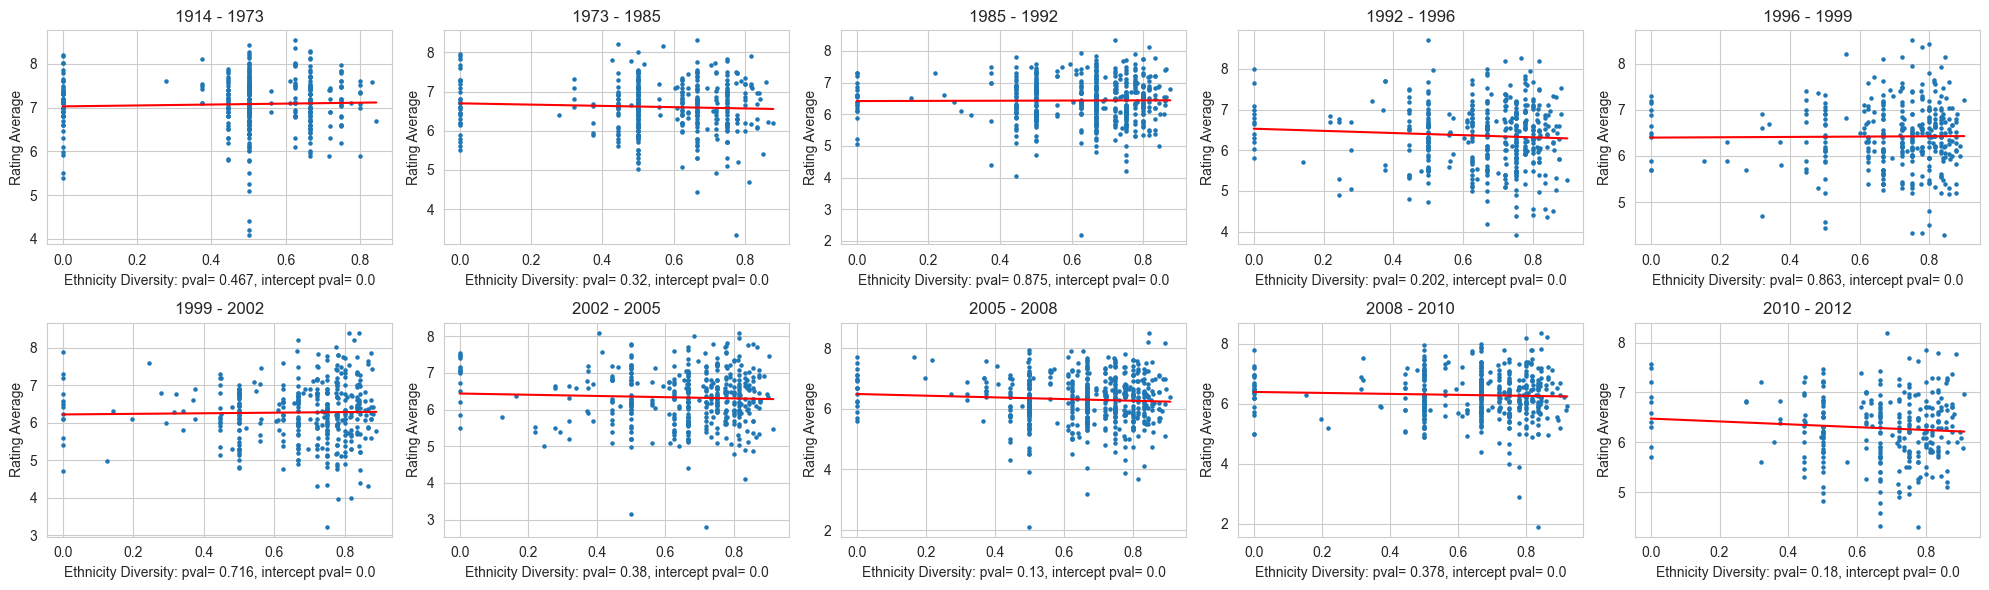

In [18]:
plot_regression_line(
    balanced_df1_er, balanced_df2_er, balanced_df3_er, balanced_df4_er, balanced_df5_er,
    balanced_df6_er, balanced_df7_er, balanced_df8_er, balanced_df9_er, balanced_df10_er,
    mod1_er, mod2_er, mod3_er, mod4_er, mod5_er, mod6_er, mod7_er, mod8_er, mod9_er, mod10_er,
    cutoff_er,'ethnicity_diversity', 'rating_average', 'Ethnicity Diversity', 'Rating Average'
)


### Gender - Ratings

In [19]:
gen_div_filter_r = filtering(gen_div,'rating')
print('Size of Gender :',gen_div_filter_r.shape[0])
period_df_gr ,cutoff_gr = year_release_split(gen_div_filter_r, 10)
# tot =0
# for i in range(1,nbr+1):
#     print(i,":",period_df_gr[f'df_period{i}'].shape[0])
#     tot = tot + period_df_gr[f'df_period{i}'].shape[0]
# print(tot)

Size of Gender : 6583


In [20]:
balanced_df1_gr, mod1_gr = regression(period_df_gr['df_period1'], 'rating_average ~ gender_diversity', 'rating')
balanced_df2_gr, mod2_gr = regression(period_df_gr['df_period2'], 'rating_average ~ gender_diversity', 'rating')
balanced_df3_gr, mod3_gr = regression(period_df_gr['df_period3'], 'rating_average ~ gender_diversity', 'rating')
balanced_df4_gr, mod4_gr = regression(period_df_gr['df_period4'], 'rating_average ~ gender_diversity', 'rating')
balanced_df5_gr, mod5_gr = regression(period_df_gr['df_period5'], 'rating_average ~ gender_diversity', 'rating')
balanced_df6_gr, mod6_gr = regression(period_df_gr['df_period6'], 'rating_average ~ gender_diversity', 'rating')
balanced_df7_gr, mod7_gr = regression(period_df_gr['df_period7'], 'rating_average ~ gender_diversity', 'rating')
balanced_df8_gr, mod8_gr = regression(period_df_gr['df_period8'], 'rating_average ~ gender_diversity', 'rating')
balanced_df9_gr, mod9_gr = regression(period_df_gr['df_period9'], 'rating_average ~ gender_diversity', 'rating')
balanced_df10_gr, mod10_gr = regression(period_df_gr['df_period10'], 'rating_average ~ gender_diversity', 'rating')


treatment size: 303
control size: 361
treatment size: 333
control size: 357
treatment size: 334
control size: 334
treatment size: 317
control size: 319
treatment size: 373
control size: 387
treatment size: 328
control size: 328
treatment size: 279
control size: 297
treatment size: 330
control size: 355
treatment size: 417
control size: 418
treatment size: 188
control size: 188


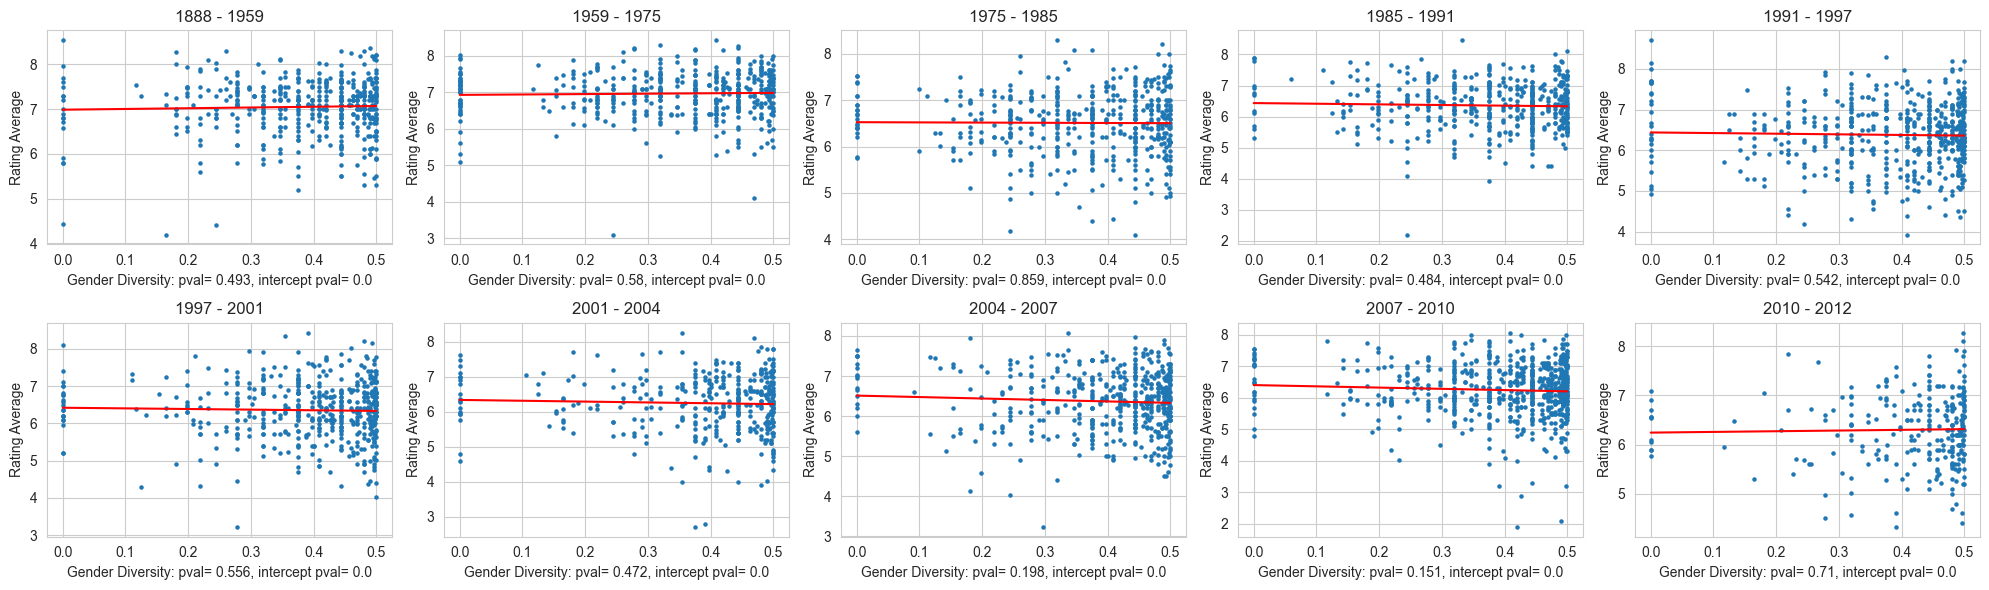

In [21]:
plot_regression_line(
    balanced_df1_gr, balanced_df2_gr, balanced_df3_gr, balanced_df4_gr, balanced_df5_gr,
    balanced_df6_gr, balanced_df7_gr, balanced_df8_gr, balanced_df9_gr, balanced_df10_gr,
    mod1_gr, mod2_gr, mod3_gr, mod4_gr, mod5_gr, mod6_gr, mod7_gr, mod8_gr, mod9_gr, mod10_gr,
    cutoff_gr,'gender_diversity', 'rating_average', 'Gender Diversity', 'Rating Average'
)
